In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import readsav
from scipy.signal import savgol_filter

---

# read all data

In [28]:
filenameList.index("m20170102_15355_MM.sav")

60

In [29]:
path = "/nwork/kouui/dstsp/data/calibration/save/"

filenameList = []
angleList    = []

with open(path+"memo.txt") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i in [52,61, 67, 68]:
            # skip an extra 0 deg,-18deg(no .save file) and -30(bad data), -31.99 deg(bad data)
            continue
        temp = line[:-2].split()
        filenameList.append(temp[0][:-5]+"_MM.sav")
        angleList.append( float(temp[1]) )
        
angleArray = np.array( angleList )

In [30]:
nAngle = len(filenameList)

plot of original Mueller Matrix

In [34]:
saveFile = readsav(path+filenameList[0])
mm = saveFile['mm']
wl = saveFile['wl']
x0, x1 = 650,2050

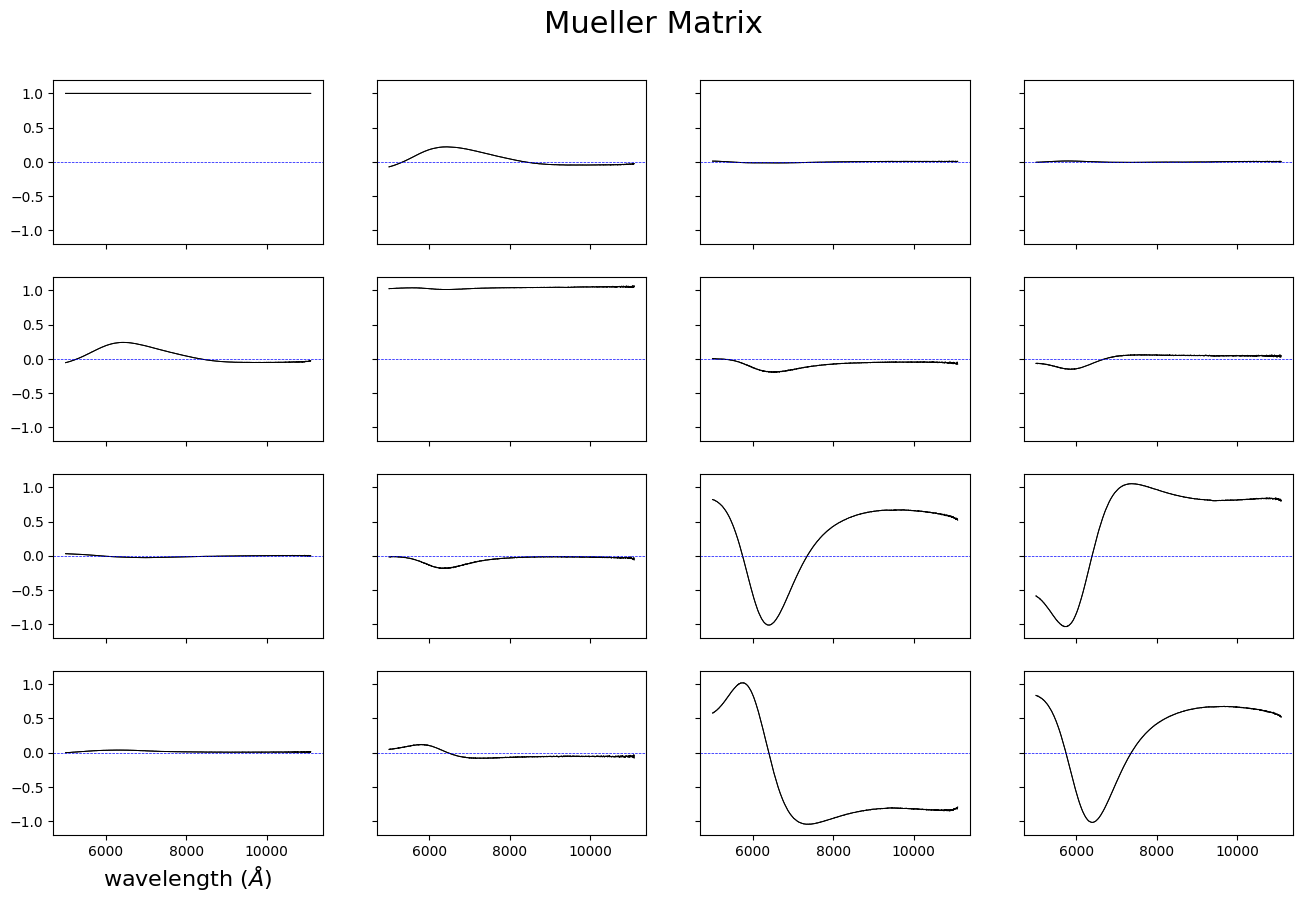

In [36]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=100, sharex=True, sharey=True)

for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wl[x0:x1]*10, mm[x0:x1,i,j]/mm[x0:x1,0,0], '-k', linewidth=0.7)
        ax.plot(wl[x0:x1]*10, mmsOrigin[:,0,i,j], '-k', linewidth=0.7)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Mueller Matrix', x=0.5, y=0.95, fontsize=22);

try Savitzky-Golay filter

row:  0 col:  1
row:  0 col:  2
row:  0 col:  3
row:  1 col:  0
row:  1 col:  1
row:  1 col:  2
row:  1 col:  3
row:  2 col:  0
row:  2 col:  1
row:  2 col:  2
row:  2 col:  3
row:  3 col:  0
row:  3 col:  1
row:  3 col:  2
row:  3 col:  3


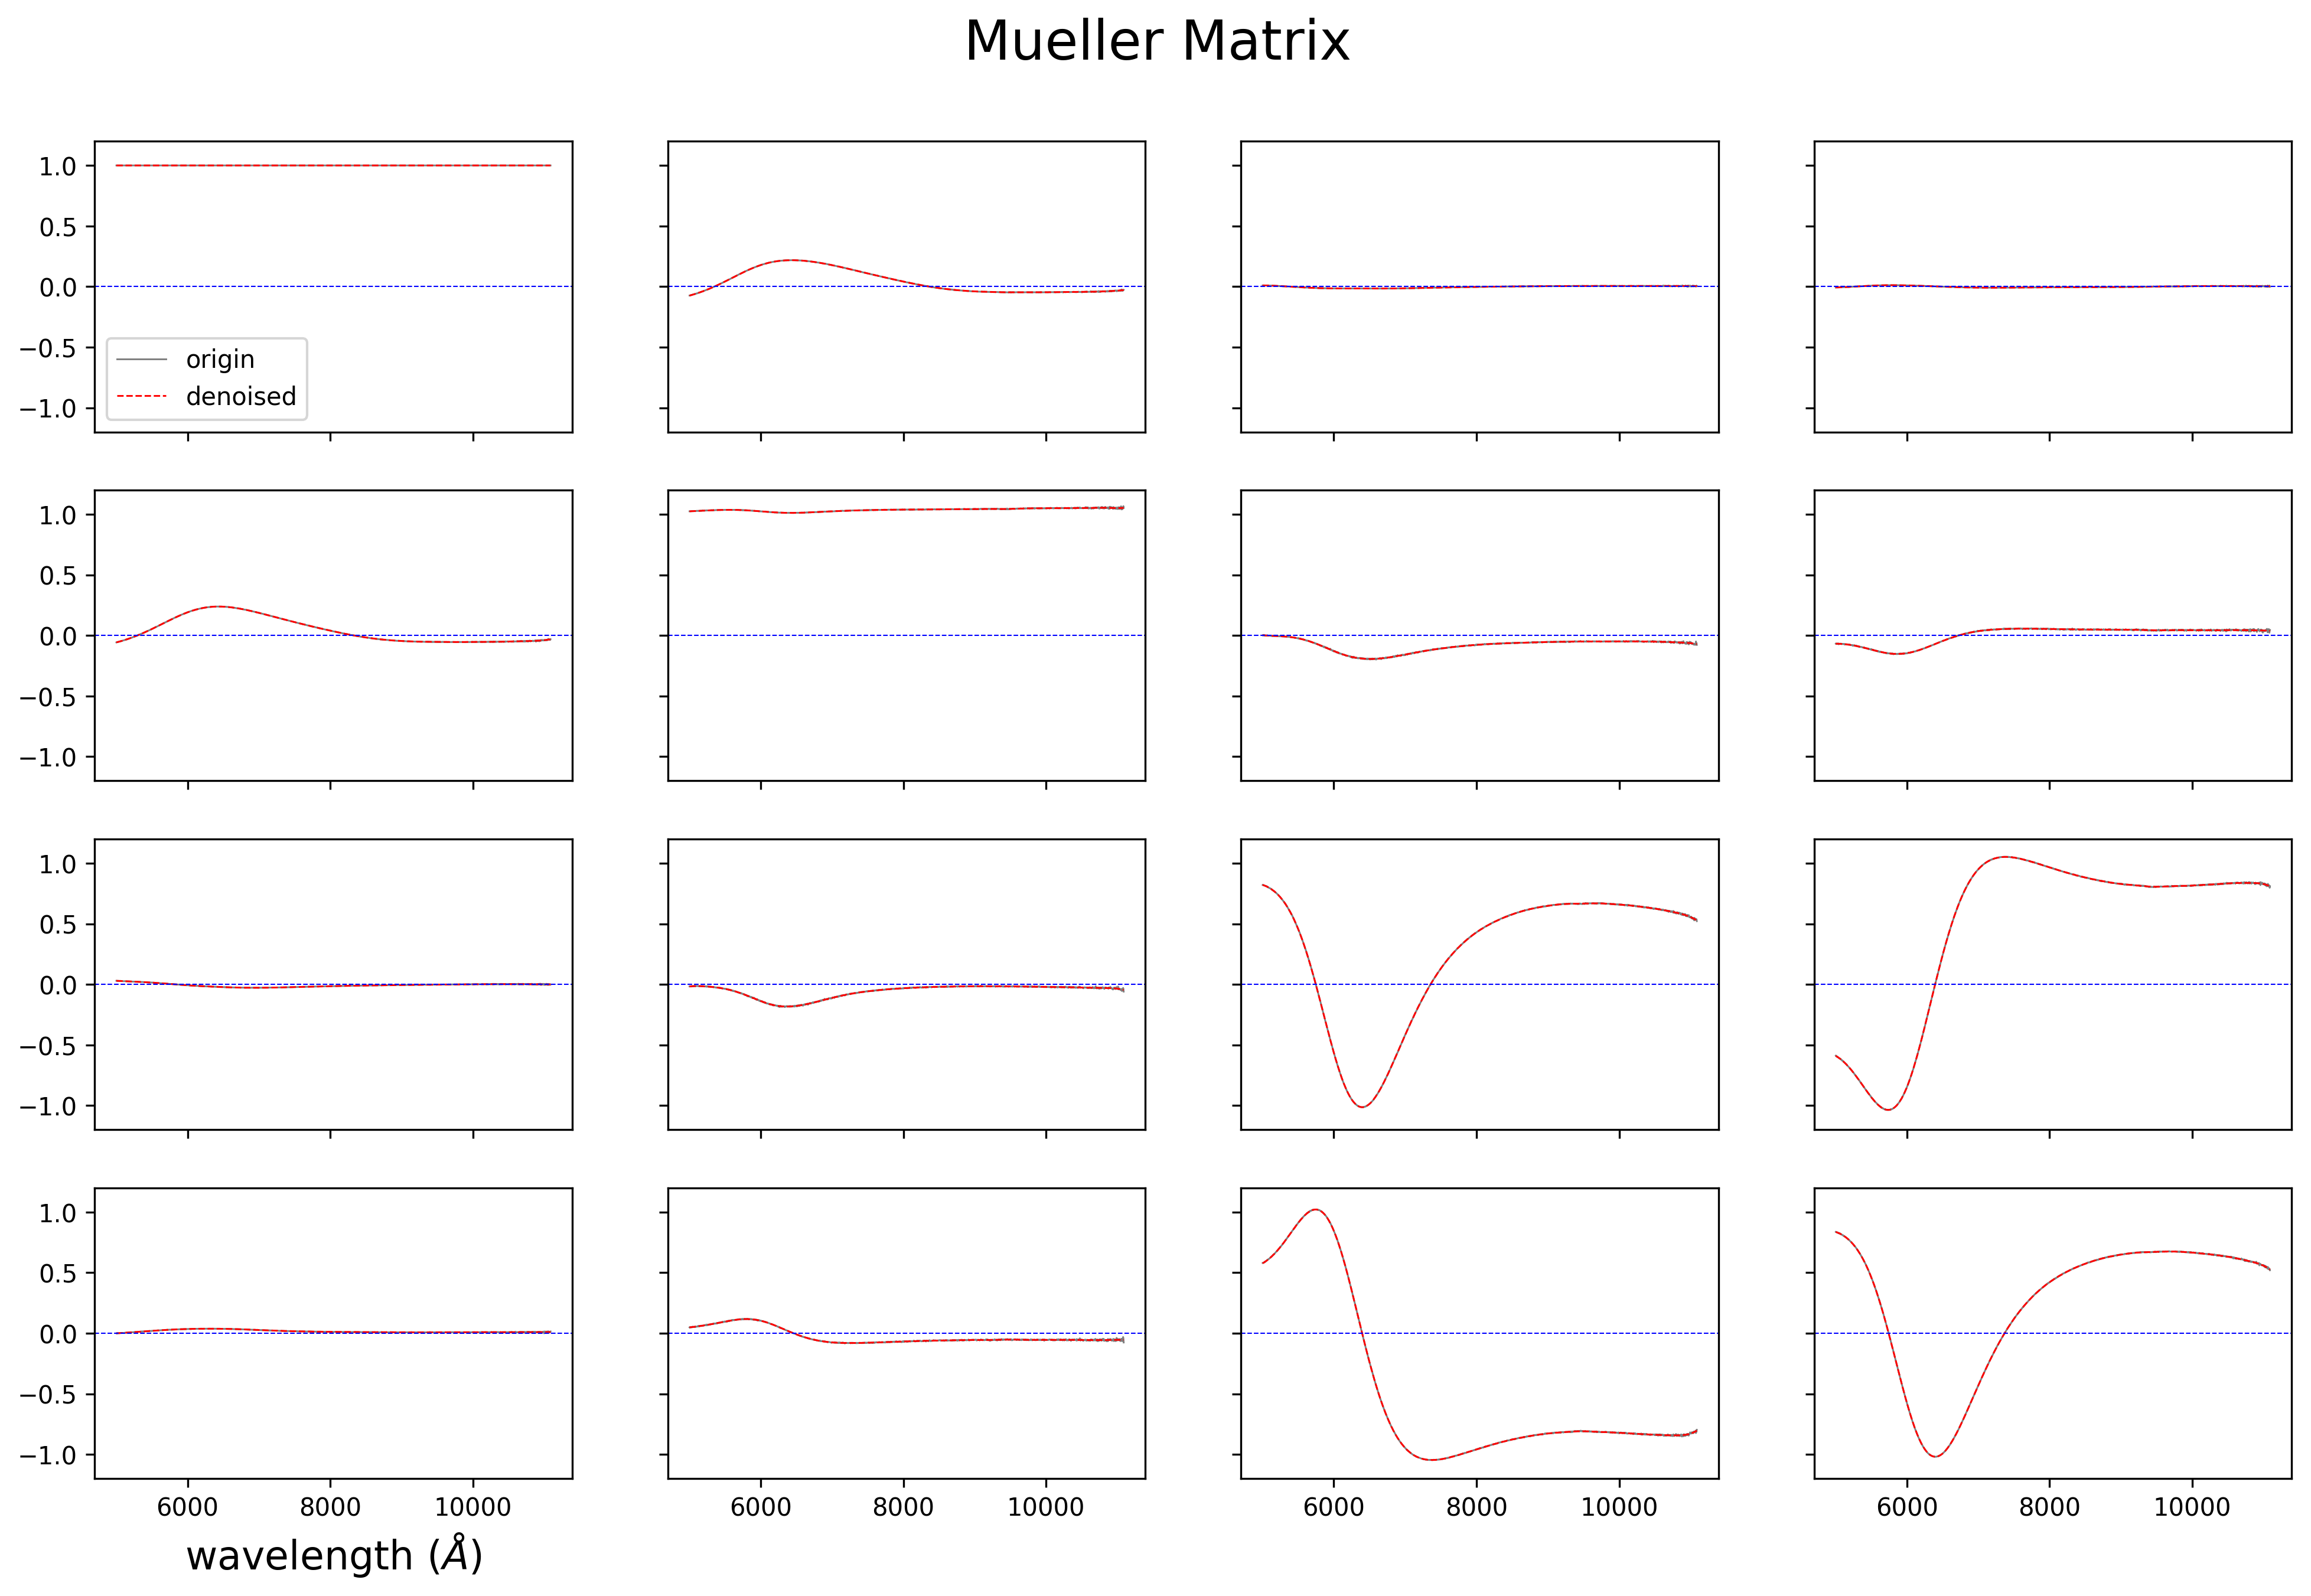

In [18]:
# try 
N = x1-x0
mmFilter = np.ones((N,4,4))
wlFilter = saveFile['wl'][x0:x1].copy()

for i in range(4):
    for j in range(4):
        if i==0 and j==0:
            continue
        print("row: ",i,"col: ", j)
        temp = saveFile['mm'][x0:x1,i,j]/saveFile['mm'][x0:x1,0,0]
        mmFilter[:,i,j] = savgol_filter(temp, 201, 5)
        
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wl[x0:x1]*10, mm[x0:x1,i,j]/mm[x0:x1,0,0], '-k', linewidth=0.7, alpha=0.5, label="origin")
        ax.plot(wlFilter*10, mmFilter[:,i,j], '--r', linewidth=0.7, label="denoised")
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Mueller Matrix', x=0.5, y=0.95, fontsize=22);

read all Mueller Matrices

In [32]:
nWave = x1 - x0 

In [33]:
mmsOrigin = np.ones((nWave,nAngle,4,4))
for i, filename in enumerate(filenameList):
    saveFile = readsav(path+filename)
    mmsOrigin[:,i,:,:] = saveFile["mm"][x0:x1,:,:]/saveFile["mm"][x0:x1,0,0].reshape(-1,1,1)

In [40]:
print("size of mmsOrigi: {}MB".format(mmsOrigin.nbytes /1024/1024))

size of mmsOrigi: 17.7734375MB


now let's denoise by Savitzky-Golay filter

In [41]:
mmsFilter = np.ones((nWave,nAngle,4,4))

for nA in range(nAngle):
    for i in range(4):
        for j in range(4):
            if i==0 and j==0:
                continue
            mmsFilter[:,nA,i,j] = savgol_filter(mmsOrigin[:,nA,i,j], 201, 5)


lets check whether savgol_filter made mistakes

In [43]:
res = abs(mmsFilter - mmsOrigin)
res.max(), res.min(), res.mean(), res.std()

(0.034195864051795644, 0.0, 0.00089890722062982301, 0.0012345988910165879)

In [58]:
for i in range(4):
    for j in range(4):
        print("res max at row {} col {} is {}".format(i,j,res[:,:2,i,j].max()))

res max at row 0 col 0 is 0.0
res max at row 0 col 1 is 0.0066342968941661105
res max at row 0 col 2 is 0.007343551664288645
res max at row 0 col 3 is 0.008216827283350187
res max at row 1 col 0 is 0.01036126898364971
res max at row 1 col 1 is 0.015394505587088325
res max at row 1 col 2 is 0.02062536523078501
res max at row 1 col 3 is 0.030471850718319156
res max at row 2 col 0 is 0.006972219957393486
res max at row 2 col 1 is 0.021034745575408534
res max at row 2 col 2 is 0.012666186856788775
res max at row 2 col 3 is 0.013558056644466188
res max at row 3 col 0 is 0.009913787310660355
res max at row 3 col 1 is 0.022902915093591637
res max at row 3 col 2 is 0.016080801772415887
res max at row 3 col 3 is 0.012324911691010576


looks good, lets check by plotting them together

ok! figures also looks good. let's save them to one .npz file

In [73]:
%timeit npzfile = np.load("/nwork/kouui/dstsp/data/calibration/save/mmirFilter.npz")

637 µs ± 54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


we see that loading `npz` file is very fast, much much faster than restoring `.sav` file

---